## CLASIFICACIÓN TODOS LOS MODELOS

In [1]:
!pip3 install matplotlib

In [2]:
import pandas as pd
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from pprint import pprint

import numpy as np
import spacy
import unicodedata
import os
#from spellchecker import SpellChecker 
#from textblob import TextBlob 
#import contractions
import re
import random


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# 1. CARGA DE COJUNTOS DE NOTICIAS Y DE GLOSARIOS
Cargamos los cojuntos que contienen las noticias tanto para el entrenamiento como para el test. Hay un glosario por cada una de las categorias de noticias que tenemos.

Lo primero que necesitamos es cargar nuestros glosarios de términos para crear nuestro diccionario

In [3]:
def cargar_glosario(categoria, conjunto):
    fname = f"../Datos/Glosarios/{conjunto}/glosario_{categoria}.txt"

    glosario = []
    with open(fname, 'r') as f:
        glosario = [termino.rstrip('\n') for termino in f.readlines()]
    return glosario

In [4]:
categorias = ["deportes", "salud", "ciencia", "politica"]

glosarios = {}
for categoria in categorias:
    glosarios[categoria] = cargar_glosario(categoria, "train")

pprint(glosarios)

{'ciencia': ['vacao',
             'llama',
             'captura',
             'cola',
             'honor',
             'gemanidas',
             'banyoles',
             'neandertal',
             'agujero',
             'latigo',
             'supersa',
             'perfecto',
             'regalo',
             'bankman',
             'fried',
             'navidad',
             'estampido',
             'ftx',
             'york',
             'menta',
             'supermasivo',
             'barrera',
             'segundo',
             'ingeniero',
             'magic',
             'reencuentro',
             'leo',
             'nif',
             'cernan',
             'fauci'],
 'deportes': ['falso',
              'jamas',
              'smash',
              'mbappe',
              'gigante',
              'reserva',
              'nets',
              'carpena',
              'djokovic',
              'mclaren',
              'exencion',
              'butler',
    

In [5]:
glosarios_t = {}
for categoria in categorias:
    glosarios_t[categoria] = cargar_glosario(categoria, "test")

pprint(glosarios_t)


{'ciencia': ['sal',
             'cuantico',
             'idioma',
             'fraa',
             'vacuna',
             'isidro',
             'santo',
             'llnl',
             'agujero',
             'sonido',
             'antageno',
             'subtipo',
             'quipus',
             'congelacia',
             'ska',
             'ofensivo',
             'palabrota',
             'canaria',
             'relatividad',
             'estruendo',
             'programador',
             'telescopio',
             'congelar',
             'gripe',
             'alineacia',
             'almanaque',
             'escarcha',
             'helada',
             'sevilla',
             'alphacode'],
 'deportes': ['seguidor',
              'carlos',
              'mans',
              'warren',
              'doncic',
              'suarez',
              'juancho',
              'boston',
              'estabilidad',
              'horford',
              'hernanga',
 

Creamos nuestro diccionario de palabras en base a los terminos de todos los glosarios

In [6]:
def create_dictionary(glosarios):
    doc_tokens = [[termino for termino in glosario] for glosario in glosarios.values()]
    dictionary = corpora.Dictionary(doc_tokens)
    return dictionary

In [7]:
def create_dictionary_glos(glosario):
    dictionary = corpora.Dictionary(glosario)
    return dictionary

In [8]:
for g in glosarios.keys():
    if g == "deportes":
        deportes_dic = create_dictionary_glos([glosarios[g]])
    if g == "salud":
        salud_dic = create_dictionary_glos([glosarios[g]])
    if g == "ciencia":
        ciencia_dic = create_dictionary_glos([glosarios[g]])
    else:
        politica_dic = create_dictionary_glos([glosarios[g]])
    

In [9]:
for g in glosarios_t.keys():
    if g == "deportes":
        salud_dic_t = create_dictionary_glos([glosarios_t[g]])
    if g == "salud":
        salud_dic_t = create_dictionary_glos([glosarios_t[g]])
    if g == "ciencia":
        ciencia_dic_t = create_dictionary_glos([glosarios_t[g]])
    else:
        politica_dic_t = create_dictionary_glos([glosarios_t[g]])

In [10]:
glosarios_dict = create_dictionary(glosarios)
print(glosarios_dict)

print("-"*100)

glosarios_dict_t = create_dictionary(glosarios_t)
print(glosarios_dict_t)

Dictionary<140 unique tokens: ['arabia', 'booker', 'butler', 'campazzo', 'carpena']...>
----------------------------------------------------------------------------------------------------
Dictionary<139 unique tokens: ['aerodinamico', 'booker', 'boston', 'brooklyn', 'cancha']...>


Cargamos nuestras noticias de test y las convertimos a un bag of words utilizando nuestro diccionario

In [11]:
noticias_train_dataframe = pd.read_csv("../Datos/noticias_train.csv")
noticias_test_dataframe = pd.read_csv("../Datos/noticias_test.csv")

In [12]:
display(noticias_train_dataframe)

,index,category,n_doc,title,path,link,docs,corpus
0,57,sports,58,El 'efecto Alonso' transforma a Aston Martin -...,./Datos/Raw_data/sports/58.txt,https://news.google.com/__i/rss/rd/articles/CB...,"Mike Krack, director del cuadro británico, con...",Mike Krack director cuadro britanico confesar ...
1,47,sports,48,"""Es el mismo Alonso que con Minardi hace 20 añ...",./Datos/Raw_data/sports/48.txt,https://news.google.com/__i/rss/rd/articles/CB...,De la Rosa defiende la valía de Fernando pese ...,Rosa defender valia Fernando pese 41 ano astur...
2,28,sports,29,Devin Booker y Jayson Tatum nombrados jugadore...,./Datos/Raw_data/sports/29.txt,https://news.google.com/__i/rss/rd/articles/CB...,La NBA acaba de publicar sus tradicionales pre...,NBA acabar publicar tradicional premio mensual...
3,40,sports,41,Ferrero: “Trabajar con Zverev no fue fácil par...,./Datos/Raw_data/sports/41.txt,https://news.google.com/__i/rss/rd/articles/CB...,Carlos Alcaraz afrontará la temporada 2023 des...,Carlos Alcaraz afrontar temporada 2023 cima te...
4,18,sports,19,Golden State acaba con Houston al ritmo de And...,./Datos/Raw_data/sports/19.txt,https://news.google.com/__i/rss/rd/articles/CB...,QuÃ© fue de aquel Andrew Wiggins que llegÃ³ a ...,QuA Andrew Wiggins llega3 objeto burla remonta...
...,...,...,...,...,...,...,...,...
115,224,politics,45,El Ministerio de Igualdad pacta conMoncloa una...,./Datos/Raw_data/politics/45.txt,https://elpais.com/espana/catalunya/2022-12-12...,"Xavier Trias, que fue alcalde de Barcelona ent...",Xavier Trias alcalde Barcelona 2011 2015 Conve...
116,203,politics,24,El Poder Judicial propone mantener laobligació...,./Datos/Raw_data/politics/24.txt,https://www.eldiario.es/politica/pp-vox-anunci...,"Las dos derechas, PP y Vox, han reaccionado de...",derecha PP Vox reaccionar forma airado viernes...
117,228,politics,49,Sandro Rosell anunciará tras Reyes si sepresen...,./Datos/Raw_data/politics/49.txt,https://elpais.com/espana/madrid/2022-12-12/al...,Javier Ortega Smith lleva un tatuaje en un bra...,Javier Ortega Smith tatuaje brazo poner COE 13...
118,208,politics,29,España y el bloque de países por un límite baj...,./Datos/Raw_data/politics/29.txt,https://www.eldiario.es/politica/fraude-fiscal...,"SegÃºn Larsen, las amenazas de âPaul Bonâ ...",segaon Larsen amenaza aPaul Bona mantener mayo...


In [13]:
display(noticias_test_dataframe)

,index,category,n_doc,title,path,link,docs,corpus
0,21,sports,22,Houston da la sorpresa remontando y derrotando...,./Datos/Raw_data/sports/22.txt,https://news.google.com/__i/rss/rd/articles/CB...,Jalen Green y los jóvenes Rockets sonrieron an...,Jalen Green joven Rockets sonreir anoche terri...
1,5,sports,6,"Cristiano Ronaldo exige a la Juventus 19,9 mil...",./Datos/Raw_data/sports/6.txt,https://news.google.com/__i/rss/rd/articles/CB...,El portugués reclama al club italiano los sala...,portugues reclamar club italiano salario pacta...
2,48,sports,49,Alpine comenzó 2022 “en ruinas” - AS,./Datos/Raw_data/sports/49.txt,https://news.google.com/__i/rss/rd/articles/CB...,Alpine llegaba con grandes esperanzas a 2022. ...,Alpine llegar esperanza 2022 expectacion maxim...
3,13,sports,14,Boicot de Mbappé al alcohol - AS,./Datos/Raw_data/sports/14.txt,https://news.google.com/__i/rss/rd/articles/CB...,"Desde que comenzó el Mundial, Kylian Mbappé ha...",comenzar Mundial Kylian Mbappe seguir patron c...
4,46,sports,47,KTM recibe ayuda de la F1 - AS,./Datos/Raw_data/sports/47.txt,https://news.google.com/__i/rss/rd/articles/CB...,"El techo presupuestario de la F1, tan polémico...",techo presupuestario F1 polemico temporada exc...
...,...,...,...,...,...,...,...,...
115,198,politics,19,El PSOE se queda solo y no consigue limitar la...,./Datos/Raw_data/politics/19.txt,https://elpais.com/america-colombia/2022-12-08...,Castillo durÃ³ apenas un aÃ±o y medio en el po...,Castillo dura3 aao inestabilidad constante cen...
116,216,politics,37,Petro asegura que Pedro Castillo “se dejó llev...,./Datos/Raw_data/politics/37.txt,https://www.20minutos.es/noticia/5084030/0/rib...,Traducido al mensaje que tambiÃ©n la ComisiÃ³n...,traducido mensaje tambiA ComisiA3n Europea -qu...
117,221,politics,42,Meloni cancela su viaje a Alicante por unagrip...,./Datos/Raw_data/politics/42.txt,https://elpais.com/espana/2022-12-13/bolanos-s...,"Por otro lado, el presidente del grupo parlame...",presidente grupo parlamentario Unidas Jaume As...
118,195,politics,16,El número de hogares acogidos a la tarifaregul...,./Datos/Raw_data/politics/16.txt,https://elpais.com/ideas/2022-12-09/la-subjeti...,Porque ambos exabruptos tienen defensa subjeti...,exabrupto defensa subjetivo partidario cultura...


In [14]:
norm_train_corpus = noticias_train_dataframe["corpus"]
norm_test_corpus = noticias_test_dataframe["corpus"]

In [15]:
train_labels = noticias_train_dataframe["category"]
test_labels = noticias_test_dataframe["category"]

# 2. BAG OF WORDS (BOW) Y VOCABULARIO
Obtenemos las bolsas de palabras y el vocabulario (glosario) que emplea en los cojuntos de test y train

In [16]:
def create_bag_of_words(docs_list, dictionary):
    doc_tokens = [simple_preprocess(corpus) for corpus in docs_list]
    docs_bow = [dictionary.doc2bow(doc) for doc in doc_tokens]
    return docs_bow

In [17]:
def obtain_words(bow, dictionary):
    """ Funcion para obtener un bow con palabras
    - bow: docs_bow
    - dictionary: glosario
    """

    tok = []
    counts = []
    
    for i in range(len(bow)-1):
        
        for j in bow[i]:
            
            token_ids = j[0]
            token_count = j[1]

            palabra = dictionary[token_ids]
            
            if palabra not in tok:
                tok.append(palabra)
                counts.append(token_count)
    


    d = {t:count for t, count in zip(tok, counts)}
    
    return d

In [18]:
def obtain_vocab(bow, dictionary):
    """ Funcion para obtener un bow con palabras
    - bow: docs_bow
    - dictionary: glosario
    """

    tok = []
    ids = []
    
    for i in range(len(bow)-1):
        
        for j in bow[i]:
            
            token_ids = j[0]

            palabra = dictionary[token_ids]
            
            if palabra not in tok:
                tok.append(palabra)
                ids.append(token_ids)
    


    d = {count:t for t, count in zip(tok, ids)}
    
    return d

In [19]:
def voca(dictionary):
    """ Funcion para obtener un bow con palabras
    - bow: docs_bow
    - dictionary: glosario
    """

    tok = []
    ids = []
    
    for i in dictionary.keys():

        palabra = dictionary[i]
        
        if palabra not in tok:
            tok.append(palabra)
            ids.append(i)
    


    d = {t:count for t, count in zip(tok, ids)}
    
    return d

Ahora es momento de crear una bag of words para cada noticia en base a nuestro diccionario

In [20]:
vocabulario_train = voca(glosarios_dict)
vocabulario_train

{'arabia': 0,
 'booker': 1,
 'butler': 2,
 'campazzo': 3,
 'carpena': 4,
 'cd': 5,
 'club': 6,
 'collins': 7,
 'cristiano': 8,
 'cuento': 9,
 'djokovic': 10,
 'domenicali': 11,
 'enrique': 12,
 'exencion': 13,
 'falso': 14,
 'florentino': 15,
 'formato': 16,
 'gavi': 17,
 'gigante': 18,
 'gonzalez': 19,
 'gonzalo': 20,
 'heredero': 21,
 'indycar': 22,
 'jamas': 23,
 'jimmy': 24,
 'juventus': 25,
 'luis': 26,
 'madrid': 27,
 'magnussen': 28,
 'marbella': 29,
 'mbappe': 30,
 'mclaren': 31,
 'nets': 32,
 'pagar': 33,
 'palou': 34,
 'porra': 35,
 'premio': 36,
 'real': 37,
 'reserva': 38,
 'residencia': 39,
 'ronaldo': 40,
 'rosa': 41,
 'rotacion': 42,
 'serbia': 43,
 'serbio': 44,
 'smash': 45,
 'steiner': 46,
 'tatum': 47,
 'tenerife': 48,
 'verdasco': 49,
 'aceite': 50,
 'afiliado': 51,
 'anemia': 52,
 'arterial': 53,
 'cafa': 54,
 'cannabis': 55,
 'condiloma': 56,
 'coosalud': 57,
 'creatividad': 58,
 'dash': 59,
 'epilepsia': 60,
 'eps': 61,
 'folcodina': 62,
 'genital': 63,
 'ips': 6

In [21]:
vocabulario_test = voca(glosarios_dict_t)
vocabulario_test

{'aerodinamico': 0,
 'booker': 1,
 'boston': 2,
 'brooklyn': 3,
 'cancha': 4,
 'carlos': 5,
 'celtics': 6,
 'colombia': 7,
 'dolares': 8,
 'doncic': 9,
 'enrique': 10,
 'estabilidad': 11,
 'ferrero': 12,
 'garden': 13,
 'gasto': 14,
 'gimenez': 15,
 'golden': 16,
 'grada': 17,
 'hernanga': 18,
 'horford': 19,
 'james': 20,
 'juancho': 21,
 'krack': 22,
 'ktm': 23,
 'lebron': 24,
 'leclerc': 25,
 'lesia': 26,
 'luis': 27,
 'mans': 28,
 'marko': 29,
 'mez': 30,
 'mirar': 31,
 'moto': 32,
 'ofensivo': 33,
 'pts': 34,
 'raptors': 35,
 'reb': 36,
 'resistencia': 37,
 'rez': 38,
 'sancionar': 39,
 'seguidor': 40,
 'siebert': 41,
 'stakhovsky': 42,
 'state': 43,
 'suarez': 44,
 'suns': 45,
 'tristeza': 46,
 'warren': 47,
 'warriors': 48,
 'wiggins': 49,
 'adolescente': 50,
 'alga': 51,
 'antidepresivo': 52,
 'aprovechar': 53,
 'atras': 54,
 'automatico': 55,
 'bacteria': 56,
 'bronquiolitis': 57,
 'cabello': 58,
 'congelado': 59,
 'cuadro': 60,
 'depresion': 61,
 'entrenar': 62,
 'esconder': 

In [22]:
#https://radimrehurek.com/gensim/corpora/dictionary.html

docs_bow = create_bag_of_words(noticias_train_dataframe["corpus"].values, glosarios_dict)
print(docs_bow[19])
# [(token_id, token_count)]

print("-"*100)

docs_bow_t = create_bag_of_words(noticias_test_dataframe["corpus"].values, glosarios_dict_t)
print(docs_bow_t[19])

[]
----------------------------------------------------------------------------------------------------
[(39, 1), (77, 2)]


In [23]:
vocab_train = obtain_vocab(docs_bow, glosarios_dict)
print(vocab_train)
# [(token_id, token_count)]

print("-"*100)

vocab_test = obtain_vocab(docs_bow_t, glosarios_dict_t)
print(vocab_test)

{36: 'premio', 41: 'rosa', 133: 'sentir', 1: 'booker', 47: 'tatum', 84: 'captura', 10: 'djokovic', 27: 'madrid', 44: 'serbio', 8: 'cristiano', 9: 'cuento', 12: 'enrique', 26: 'luis', 99: 'navidad', 22: 'indycar', 31: 'mclaren', 34: 'palou', 38: 'reserva', 102: 'perfecto', 19: 'gonzalez', 20: 'gonzalo', 72: 'presion', 97: 'magic', 103: 'reencuentro', 105: 'segundo', 114: 'consulta', 93: 'ingeniero', 125: 'nicolas', 3: 'campazzo', 6: 'club', 37: 'real', 118: 'ex', 0: 'arabia', 16: 'formato', 17: 'gavi', 35: 'porra', 95: 'leo', 5: 'cd', 48: 'tenerife', 92: 'honor', 28: 'magnussen', 46: 'steiner', 42: 'rotacion', 11: 'domenicali', 2: 'butler', 24: 'jimmy', 109: 'york', 139: 'vuelo', 123: 'negativo', 14: 'falso', 18: 'gigante', 23: 'jamas', 45: 'smash', 119: 'ja', 76: 'unicef', 33: 'pagar', 86: 'cola', 129: 'reyes', 132: 'ruido', 121: 'juventud', 52: 'anemia', 116: 'dema', 79: 'zumo', 56: 'condiloma', 63: 'genital', 77: 'verruga', 65: 'lavar', 78: 'vrs', 51: 'afiliado', 57: 'coosalud', 61: 

In [24]:
bow_train = obtain_words(docs_bow, glosarios_dict)
print(bow_train)
# [(token_id, token_count)]

print("-"*100)

bow_test = obtain_words(docs_bow_t, glosarios_dict_t)
print(bow_test)

{'premio': 1, 'rosa': 3, 'sentir': 5, 'booker': 3, 'tatum': 3, 'captura': 1, 'djokovic': 7, 'madrid': 1, 'serbio': 1, 'cristiano': 1, 'cuento': 4, 'enrique': 1, 'luis': 3, 'navidad': 2, 'indycar': 3, 'mclaren': 7, 'palou': 3, 'reserva': 5, 'perfecto': 2, 'gonzalez': 5, 'gonzalo': 5, 'presion': 2, 'magic': 2, 'reencuentro': 1, 'segundo': 1, 'consulta': 2, 'ingeniero': 1, 'nicolas': 1, 'campazzo': 5, 'club': 1, 'real': 7, 'ex': 1, 'arabia': 3, 'formato': 5, 'gavi': 4, 'porra': 4, 'leo': 1, 'cd': 4, 'tenerife': 6, 'honor': 1, 'magnussen': 6, 'steiner': 6, 'rotacion': 3, 'domenicali': 4, 'butler': 3, 'jimmy': 2, 'york': 1, 'vuelo': 1, 'negativo': 1, 'falso': 3, 'gigante': 2, 'jamas': 3, 'smash': 3, 'ja': 1, 'unicef': 3, 'pagar': 2, 'cola': 1, 'reyes': 2, 'ruido': 1, 'juventud': 1, 'anemia': 7, 'dema': 1, 'zumo': 14, 'condiloma': 8, 'genital': 15, 'verruga': 13, 'lavar': 3, 'vrs': 5, 'afiliado': 6, 'coosalud': 5, 'eps': 6, 'ips': 6, 'cannabis': 20, 'creatividad': 15, 'aceite': 2, 'pulmonar'

# 3. EXTRACCIÓN DE CARACTERISTICAS
Instanciamos los vectorizadores para obtener las características BoW y TF-IDF.  
Usamos el parámetro max_df=0.9 para eliminar los stop-words como las palabras que aparecen al menos en el 90% de los documentos y el parámetro min_df=0.01 para eliminar las palabras que no aparecen al menos en un 1% de los documentos.\

Usamos el modelo `TfidfTransformer` para calcular la matriz TF-IDF a partir del BoW y no tener que repetir todo el entrenamiento.

Para calcular los modelos basados en WV usamos el modelo gloVe pre-entrenado en `spaCy`. Calculamos dos modelos basados en word-vectors:  
* El vector promedio de los WV de todos los tokens con el mismo peso para todas las palabras.  
* Ponderando el WV de cada palabra por el término de frecuencia inversa de documento (IDF).  

Definimos las funciones para calcular estas dos matrices de características:

Sacamos las caracteristicas

In [25]:
!python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 5.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [26]:
nlp = spacy.load("es_core_news_lg") #Mejor modelo optimizado para la CPU

In [27]:
#BoW
bow_vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, vocabulary=vocabulario_train)
# bow_vectorizer_t = CountVectorizer(min_df=0.01, max_df=0.9, vocabulary=vocabulario_test)


#Tf-idf
tfidf_vectorizer = TfidfTransformer()

#Funciones de WV.
def averaged_word_vectorizer(corpus):
    '''Aplica la función de cálculo del WE promedio a todos los
    documentos del corpus (cada doc es una lista de tokens)'''
    features = [nlp(doc).vector
                    for doc in corpus]
    return np.array(features)

def tfidf_wtd_avg_word_vectors(doc, word_tfidf_map):
    '''Aplica la función de cálculo del WE ponderado por TF-IDF
    a un documento (como lista de tokens)'''
    tokens = doc.split()

    feature_vector = np.zeros((nlp.vocab.vectors_length,),dtype="float64")
    wts = 0.      
    for word in tokens:
        if nlp.vocab[word].has_vector and word_tfidf_map.get(word, 0): #sólo considera palabras conocidas
            weighted_word_vector = word_tfidf_map[word] * nlp.vocab[word].vector
            wts = wts + 1
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
        
    return feature_vector
    
def tfidf_weighted_averaged_word_vectorizer(corpus, word_tfidf_map):
    '''Aplica la función de cálculo del WE ponderado por TF-IDF a todos los
    documentos del corpus (cada doc es una lista de tokens)'''                                       
    features = [tfidf_wtd_avg_word_vectors(doc, word_tfidf_map)
                    for doc in corpus]
    return np.array(features)

In [28]:
# características bag of words
bow_train_features = bow_vectorizer.fit_transform(norm_train_corpus)  
bow_test_features = bow_vectorizer.transform(norm_test_corpus) 

# características tfidf (a partir del BoW)
tfidf_train_features = tfidf_vectorizer.fit_transform(bow_train_features)
tfidf_test_features = tfidf_vectorizer.transform(bow_test_features)    

# características averaged word vector
avg_wv_train_features = averaged_word_vectorizer(norm_train_corpus)                
avg_wv_test_features = averaged_word_vectorizer(norm_test_corpus)      

# características tfidf weighted averaged word vector
word_tfidf_map = {key:value for (key, value) in zip(bow_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_)}

tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(norm_train_corpus, word_tfidf_map)

tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(norm_test_corpus, word_tfidf_map) 

In [29]:
bow_train_features.shape

(120, 140)

In [30]:
bow_vectorizer.get_feature_names_out()

array(['arabia', 'booker', 'butler', 'campazzo', 'carpena', 'cd', 'club',
       'collins', 'cristiano', 'cuento', 'djokovic', 'domenicali',
       'enrique', 'exencion', 'falso', 'florentino', 'formato', 'gavi',
       'gigante', 'gonzalez', 'gonzalo', 'heredero', 'indycar', 'jamas',
       'jimmy', 'juventus', 'luis', 'madrid', 'magnussen', 'marbella',
       'mbappe', 'mclaren', 'nets', 'pagar', 'palou', 'porra', 'premio',
       'real', 'reserva', 'residencia', 'ronaldo', 'rosa', 'rotacion',
       'serbia', 'serbio', 'smash', 'steiner', 'tatum', 'tenerife',
       'verdasco', 'aceite', 'afiliado', 'anemia', 'arterial', 'cafa',
       'cannabis', 'condiloma', 'coosalud', 'creatividad', 'dash',
       'epilepsia', 'eps', 'folcodina', 'genital', 'ips', 'lavar', 'lobo',
       'manada', 'marfan', 'mascarilla', 'parasito', 'pet', 'presion',
       'pulmonar', 'quiraorgica', 'tc', 'unicef', 'verruga', 'vrs',
       'zumo', 'agujero', 'bankman', 'banyoles', 'barrera', 'captura',
       '

In [31]:
tfidf_train_features.shape

(120, 140)

In [32]:
tfidf_vectorizer.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37',
       'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46',
       'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55',
       'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64',
       'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73',
       'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82',
       'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91',
       'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100',
       'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108',
       'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116',
       'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124',
       'x125

In [33]:
avg_wv_train_features.shape

(120, 300)

In [34]:
tfidf_wv_train_features.shape

(120, 300)

## 4. CLASIFICADORES
Aplicamos distintos clasificadores a cada modelo para ver cuál funciona mejor con nuestros datos. Primero definimos unas funciones para entrenar y medir el rendimiento de los clasificadores:

In [35]:
def get_metrics(true_labels, predicted_labels):
    """Calculamos distintas métricas sobre el
    rendimiento del modelo. Devuelve un diccionario
    con los parámetros medidos"""
    
    return {
        'Accuracy': np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        3),
        'Precision': np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted',
                                               zero_division=0),
                        3),
    'Recall': np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted',
                                               zero_division=0),
                        3),
    'F1 Score': np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted',
                                               zero_division=0),
                        3)}
                        

def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    """Función que entrena un modelo de clasificación sobre
    un conjunto de entrenamiento, lo aplica sobre un conjunto
    de test y devuelve la predicción sobre el conjunto de test
    y las métricas de rendimiento"""
    # genera modelo    
    classifier.fit(train_features, train_labels)
    # predice usando el modelo sobre test
    predictions = classifier.predict(test_features) 
    # evalúa rendimiento de la predicción   
    metricas = get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)
    return predictions, metricas     

Vamos a entrenar sobre el conjunto de train y evaluamos en el conjunto de test. Guardamos métricas en una lista y resultados en otra para mostrar resumen.

In [36]:
modelLR = LogisticRegression(solver='liblinear')
modelNB = GaussianNB() #var_smoothing=1e-9
modelSVM = SGDClassifier(loss='hinge', max_iter=1000)
modelRBFSVM = SVC(gamma='scale', C=2)

modelos = [('Logistic Regression', modelLR),
           ('Naive Bayes', modelNB),
           ('Linear SVM', modelSVM),
           ('Gauss kernel SVM', modelRBFSVM)]

metricas = []
resultados = []

# Modelos con características BoW
bow_train_features_ = bow_train_features.toarray()
bow_test_features_ = bow_test_features.toarray()
for m, clf in modelos:
    prediccion, metrica = train_predict_evaluate_model(classifier=clf,
                                           train_features=bow_train_features_,
                                           train_labels=train_labels,
                                           test_features=bow_test_features_,
                                           test_labels=test_labels)
    metrica['modelo']=f'{m} BoW'
    resultados.append(prediccion)
    metricas.append(metrica)
    
# Modelos con características TF-IDF
tfidf_train_features_ = tfidf_train_features.toarray()
tfidf_test_features_ = tfidf_test_features.toarray()
for m, clf in modelos:
    prediccion, metrica = train_predict_evaluate_model(classifier=clf,
                                           train_features=tfidf_train_features_,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features_,
                                           test_labels=test_labels)
    metrica['modelo']=f'{m} tfidf'
    resultados.append(prediccion)
    metricas.append(metrica)

# Modelos con características averaged word vectors
avg_wv_train_features_ = avg_wv_train_features
avg_wv_test_features_ = avg_wv_test_features
for m, clf in modelos:
    prediccion, metrica = train_predict_evaluate_model(classifier=clf,
                                           train_features=avg_wv_train_features_,
                                           train_labels=train_labels,
                                           test_features=avg_wv_test_features_,
                                           test_labels=test_labels)
    metrica['modelo']=f'{m} averaged'
    resultados.append(prediccion)
    metricas.append(metrica)

# Modelos con características tfidf weighted averaged word vectors
tfidf_wv_train_features_ = tfidf_wv_train_features
tfidf_wv_test_features_ = tfidf_wv_test_features
for m, clf in modelos:
    prediccion, metrica = train_predict_evaluate_model(classifier=clf,
                                           train_features=tfidf_wv_train_features_,
                                           train_labels=train_labels,
                                           test_features=tfidf_wv_test_features_,
                                           test_labels=test_labels)
    metrica['modelo']=f'{m} tfidf wv'
    resultados.append(prediccion)
    metricas.append(metrica)

Conviertimos la lista de métricas en un DataFrame para observar sus valores:

In [37]:
metricas = pd.DataFrame(metricas)
metricas

,Accuracy,Precision,Recall,F1 Score,modelo
0,0.458,0.490,0.458,0.453,Logistic Regression BoW
1,0.458,0.530,0.458,0.454,Naive Bayes BoW
2,0.433,0.461,0.433,0.435,Linear SVM BoW
3,0.342,0.450,0.342,0.312,Gauss kernel SVM BoW
4,0.467,0.494,0.467,0.465,Logistic Regression tfidf
5,0.417,0.468,0.417,0.417,Naive Bayes tfidf
6,0.442,0.480,0.442,0.441,Linear SVM tfidf
7,0.467,0.471,0.467,0.466,Gauss kernel SVM tfidf
8,0.875,0.882,0.875,0.877,Logistic Regression averaged
9,0.850,0.865,0.850,0.854,Naive Bayes averaged


In [38]:
prediccion_r="../Prediccion"
metricas.to_csv(prediccion_r+'/metricas.csv', header=True, index=False)

Ordenamos las métricas por `accuracy` y muestra el mejor resultado:

In [39]:
metricas = metricas.sort_values('Accuracy',ascending=False)
metricas.head(1)

,Accuracy,Precision,Recall,F1 Score,modelo
8,0.875,0.882,0.875,0.877,Logistic Regression averaged


Mejoramos el `accuracy` a partir del juego de parametros

In [40]:
modelos = metricas['modelo'].tolist()

mejor = modelos[0]
segundo = modelos[1] 
tercero = modelos[2]
cuarto = modelos[3]

moa = [mejor, segundo, tercero, cuarto]
print(moa)


['Logistic Regression averaged', 'Naive Bayes averaged', 'Gauss kernel SVM averaged', 'Linear SVM averaged']


Los modelos funcionan mejor teniendo como entrada el promedio de tfidf sobre la función de cálculo del WE promedio a todos los documentos del corpus (cada doc es una lista de tokens)

In [41]:
def separar_modelo(modelo):
    """ funcion para separar del nombre de modelo los datos con los que ha entrenado
    - modelo: nombre del modelo
    """
    sep = modelo.split(' ')

    if sep[len(sep)-1]== "wv":
        mo = ' '.join(sep[:len(sep)-2])
    
    else:
        mo = ' '.join(sep[:len(sep)-1])


    datos = sep[len(sep)-1]
    

    return mo, datos


In [42]:
dat = []
mod = []

for i in moa:
    m, d = separar_modelo(i)
    mod.append(m)
    dat.append(d)


print(mod)
print(dat)

['Logistic Regression', 'Naive Bayes', 'Gauss kernel SVM', 'Linear SVM']
['averaged', 'averaged', 'averaged', 'averaged']


In [43]:

metricas2 = []
resultados = []


for datos, mo in zip(dat, mod):
    # DATOS
    if datos == 'Bow':
        train_features_ = bow_train_features.toarray()
        test_features_ = bow_test_features.toarray()
        
    if datos == 'tfidf':
        train_features_ = tfidf_train_features.toarray()
        test_features_ = tfidf_test_features.toarray()
        
    if datos == 'averaged':
        train_features_ = avg_wv_train_features
        test_features_ = avg_wv_test_features
        
    else: # tfidf wv
        train_features_ = tfidf_wv_train_features
        test_features_ = tfidf_wv_test_features




    # MODELOS

    if mo == 'Logistic Regression':
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

        sol = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
        
        for i in sol:
            modelLR = LogisticRegression(solver=i)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelLR,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{i} - Logistic Regression ' + datos
            resultados.append(prediccion)
            metricas2.append(metrica)
        
    if mo == 'Naive Bayes':
        # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
        var_smo = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15]
        
        for i in var_smo:
            modelNB = GaussianNB(var_smoothing=i)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelNB,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{i} - Naive Bayes ' + datos
            resultados.append(prediccion)
            metricas2.append(metrica)
        
    if mo == 'Linear SVM':
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
        loss = ["hinge", "log_loss", "log", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]

        for i in loss:
            modelSVM = SGDClassifier(loss=i, max_iter=1000)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelSVM,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{i} - Linear SVM ' + datos
            resultados.append(prediccion)
            metricas2.append(metrica)

        
    if mo == 'Gauss kernel SVM': 
        # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
        gamma = ["scale", "auto"]

        for i in gamma:
            modelRBFSVM = SVC(gamma=i, C=2)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelRBFSVM,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{i} - Gauss kernel SVM ' + datos
            resultados.append(prediccion)
            metricas2.append(metrica)


/opt/anaconda3/envs/Clasificacion_3915/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/Clasificacion_3915/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/Clasificacion_3915/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/Clasificacion_3915/lib/python3.9/site-

Conviertimos la lista de métricas en un DataFrame para observar sus valores:

In [44]:
metricas3 = pd.DataFrame(metricas2)
metricas3

,Accuracy,Precision,Recall,F1 Score,modelo
0,0.842,0.859,0.842,0.846,lbfgs - Logistic Regression averaged
1,0.875,0.882,0.875,0.877,liblinear - Logistic Regression averaged
2,0.842,0.859,0.842,0.846,newton-cg - Logistic Regression averaged
3,0.858,0.869,0.858,0.862,newton-cholesky - Logistic Regression averaged
4,0.858,0.871,0.858,0.862,sag - Logistic Regression averaged
5,0.858,0.871,0.858,0.862,saga - Logistic Regression averaged
6,0.842,0.860,0.842,0.846,0.1 - Naive Bayes averaged
7,0.842,0.858,0.842,0.846,0.01 - Naive Bayes averaged
8,0.850,0.865,0.850,0.854,0.001 - Naive Bayes averaged
9,0.850,0.865,0.850,0.854,0.0001 - Naive Bayes averaged


In [45]:
metricas3.to_csv(prediccion_r+'/metricas_mejora.csv', header=True, index=False)

Ordenamos las métricas por `accuracy` y muestra el mejor resultado:

In [46]:
metricas3 = metricas3.sort_values('Accuracy',ascending=False)
display(metricas3)

,Accuracy,Precision,Recall,F1 Score,modelo
1,0.875,0.882,0.875,0.877,liblinear - Logistic Regression averaged
26,0.867,0.873,0.867,0.868,modified_huber - Linear SVM averaged
25,0.867,0.876,0.867,0.866,log - Linear SVM averaged
3,0.858,0.869,0.858,0.862,newton-cholesky - Logistic Regression averaged
4,0.858,0.871,0.858,0.862,sag - Logistic Regression averaged
5,0.858,0.871,0.858,0.862,saga - Logistic Regression averaged
16,0.850,0.865,0.850,0.854,1e-11 - Naive Bayes averaged
13,0.850,0.865,0.850,0.854,1e-08 - Naive Bayes averaged
19,0.850,0.865,0.850,0.854,1e-14 - Naive Bayes averaged
18,0.850,0.865,0.850,0.854,1e-13 - Naive Bayes averaged


In [47]:
metricas3.head(1)

,Accuracy,Precision,Recall,F1 Score,modelo
1,0.875,0.882,0.875,0.877,liblinear - Logistic Regression averaged


# 6. PRODUCCIÓN

Comenzamos implementando uno de los modelos que mejor funciona: liblinear - Logistic Regression averaged.

In [48]:
modelos = metricas3['modelo'].tolist()

mejor = modelos[0]
segundo = modelos[1] 
tercero = modelos[2]
# cuarto = modelos[3]

moa2 = [mejor, segundo, tercero] #, cuarto
print(moa2)

['liblinear - Logistic Regression averaged', 'modified_huber - Linear SVM averaged', 'log - Linear SVM averaged']


In [49]:
dat = []
mod = []
params = []

for i in moa2:
    m, d = separar_modelo(i)
    
    dat.append(d)

    p = m.split('-')
    para = p[0]
    mdo = ' '.join(p[1:])
    params.append(para.strip())
    mod.append(mdo.strip())


print(mod)
print(dat)
print(params)

['Logistic Regression', 'Linear SVM', 'Linear SVM']
['averaged', 'averaged', 'averaged']
['liblinear', 'modified_huber', 'log']


In [50]:
def produccion(mod, dat, params): 
    """ Funcion para crear los tres mejores modelos en produccion
    - mod: lista con los nombres de modelos
    - dat: lista con los datos de los mejores modelos
    - params: lista de los parametros correspondientes a los modelos
    """

    resultados2 = []
    metricas4 = []
    clasificadores = []
    
    for datos, mo, param in zip(dat, mod, params):

        # DATOS
        if datos == 'Bow':
            train_features_ = bow_train_features.toarray()
            test_features_ = bow_test_features.toarray()
            
        if datos == 'tfidf':
            train_features_ = tfidf_train_features.toarray()
            test_features_ = tfidf_test_features.toarray()
            
        if datos == 'averaged':
            train_features_ = avg_wv_train_features
            test_features_ = avg_wv_test_features
            
        else: # tfidf wv
            train_features_ = tfidf_wv_train_features
            test_features_ = tfidf_wv_test_features




        # MODELOS

        if mo == 'Logistic Regression':
            # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

            
            modelLR = LogisticRegression(solver=param)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelLR,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{param} - Logistic Regression'
            resultados2.append(prediccion)
            metricas4.append(metrica)
            clasificadores.append(modelLR)
            
        if mo == 'Naive Bayes':
            # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
            
            modelNB = GaussianNB(var_smoothing=param)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelNB,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{param} - Naive Bayes'
            resultados2.append(prediccion)
            metricas4.append(metrica)
            clasificadores.append(modelNB)
            
        if mo == 'Linear SVM':
            # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

            modelSVM = SGDClassifier(loss=param, max_iter=1000)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelSVM,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{param} - Linear SVM'
            resultados2.append(prediccion)
            metricas4.append(metrica)
            clasificadores.append(modelSVM)

            
        if mo == 'Gauss kernel SVM': 
            # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
            
            modelRBFSVM = SVC(gamma=param, C=2)
            prediccion, metrica = train_predict_evaluate_model(classifier=modelRBFSVM,
                                                train_features=train_features_,
                                                train_labels=train_labels,
                                                test_features=test_features_,
                                                test_labels=test_labels)
            metrica['modelo']=f'{param} - Gauss kernel SVM'
            resultados2.append(prediccion)
            metricas4.append(metrica)
            clasificadores.append(modelRBFSVM)

    
    return resultados2, metricas4, clasificadores

In [51]:
resultados2, metricas4, clasificadores = produccion(mod, dat, params)

/opt/anaconda3/envs/Clasificacion_3915/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [52]:
metricas5 = pd.DataFrame(metricas4)
metricas5

,Accuracy,Precision,Recall,F1 Score,modelo
0,0.875,0.882,0.875,0.877,liblinear - Logistic Regression
1,0.833,0.852,0.833,0.837,modified_huber - Linear SVM
2,0.842,0.859,0.842,0.846,log - Linear SVM


In [53]:
metricas5.to_csv(prediccion_r+'/metricas_produccion.csv', header=True, index=False)

In [54]:
predi = []
vf = []
labs = []

for c, i in zip(moa2,resultados2):
    q = [c for n in range(len(i))]
    
    for f, g, r in zip(i,q, test_labels):
        predi.append(g)
        vf.append(f)
        labs.append(r)


print(len(predi))
print(len(vf))
print(len(labs))

# 3 modelos x 120 noticias = 360

360
360
360


In [55]:
res = pd.DataFrame()
res['modelo'] = vf
res['prediccion'] = predi
res['category'] = labs

display(res)

,modelo,prediccion,category
0,sports,liblinear - Logistic Regression averaged,sports
1,politics,liblinear - Logistic Regression averaged,sports
2,sports,liblinear - Logistic Regression averaged,sports
3,sports,liblinear - Logistic Regression averaged,sports
4,sports,liblinear - Logistic Regression averaged,sports
...,...,...,...
355,politics,log - Linear SVM averaged,politics
356,politics,log - Linear SVM averaged,politics
357,politics,log - Linear SVM averaged,politics
358,politics,log - Linear SVM averaged,politics


In [56]:
res.to_csv('../Prediccion/predicciones.csv')

Ahora clasificamos

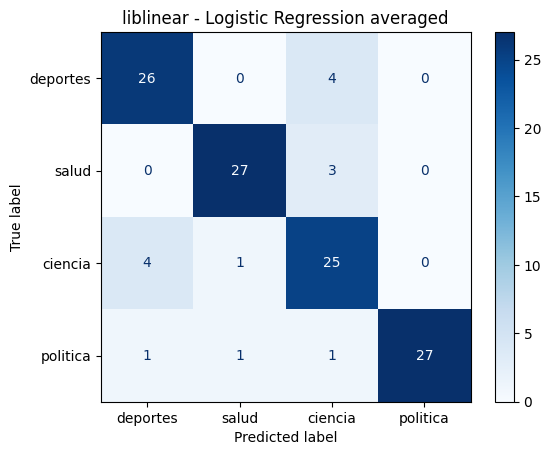

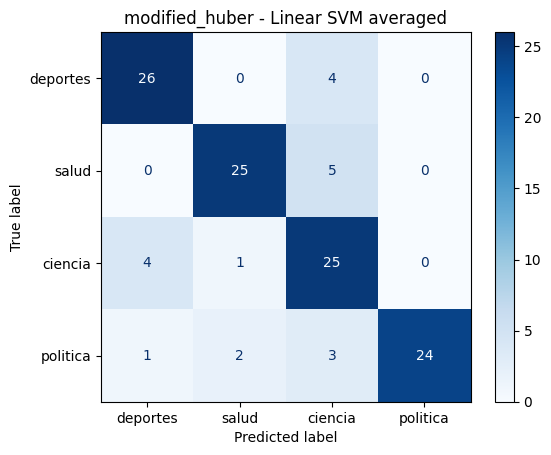

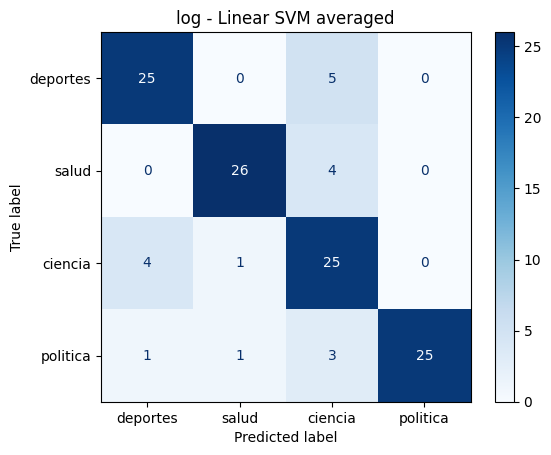

In [57]:
for title, classifier in zip(moa2, clasificadores):
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_features_,
        test_labels,
        display_labels=categorias,
        cmap=plt.cm.Blues,
        normalize=None,
    )

    disp.ax_.set_title(title)
    plt.savefig('../Prediccion/'+title+".jpg")

    
    # print(title)
    # print(disp.confusion_matrix)